# Continuous signaling games and auto-encoders

In a signaling game, two agents, a sender and a receiver communicates about a situation through a fixed language (REFERENCES). Successful communication is achieved when the receiver takes the appropriate action, or acquired the appropriate belief, based on the sender's message. In machine learning parlance, this is called an auto-encoder (REFERENCES): a system that aims at matching its output with its input as much as possible, even though intermediate steps in the process (neural layers) cannot possibly encode that much information. In essence, the middle layer is a step where information is compressed, and as such can be seen as a language of communication between the upstream and downstream parts of the system.

An important difference between signaling games and auto-encoders is that the intermediate layer in the tradition of signaling games, the language, is made of a discrete set of units. This is because studies in signaling games are concerned with actual languages, conceived as made of discrete units, words. We propose to relax the discreteness assumption, and see what can be nonetheless said about language, if anything, from the standard and powerful learning techniques of auto-encoders.

# Requirements

In [2]:
%matplotlib inline
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

# The game

The relevant elements of the game are:
- A **sender** and a **receiver**, both of which are neural nets, typically the encoder and decoder parts of an auto-encoder.
- **Situations**: both sender and receiver see (i.e. take as input) the current situation
- **Targets**: sender sees them (as input), receiver must guess them (as output).
- **Functions** targets are derived from the situation through the application of a restricted set of functions: $f_1$, $f_2$, ... Ideally, the messages (see below) should have these functions as "meanings".
- **Messages**: are sent by sender to receiver, that is, they are the output of the sender, and (part of) the input of the receiver.

At each run of the game:
- Nature picks a situation $S$ and a function $f_k$.
- The target $T$ is determined by applying the chosen function to the chosen situation: $f_k(S)$.
- Sender sees the situation $S$ and the target $f_k(S)$.
- Sender picks a messsage $M$.
- Receiver sees the situation and the message.
- Receiver makes a guess $G$ about the target $T$.

Success is measured as the proximity between the guess and the target.

Unlike usual signaling games, messages are not discrete but mere continuous vectors.

# Architecture

We use an auto-encoder network with 3 linear layers for the encoder and decoder. The activations in the middle layer are thought of as the message. 

The general situation is injected in two places in the network: at its begining and at the middle layer, the message.

The target is computed as various linear functions of the situation.

In [1]:
class Game(nn.Module):
    def __init__(self, situation_size, message_size, prediction_size, func_size, hidden_size, transform=0):
        super(Game, self).__init__()
        self.situation_size = situation_size
        self.message_size = message_size
        self.prediction_size = prediction_size
        self.func_size = func_size
        self.transform = transform
        self.criterion = nn.MSELoss()
        self.epoch = 0
        self.loss_list = []

        self.linear1_1 = nn.Linear(situation_size+prediction_size, hidden_size)
        self.linear1_2 = nn.Linear(hidden_size, hidden_size)
        self.linear1_3 = nn.Linear(hidden_size, message_size)

        self.linear2_1 = nn.Linear(situation_size+message_size, hidden_size)
        self.linear2_2 = nn.Linear(hidden_size, hidden_size)
        self.linear2_3 = nn.Linear(hidden_size, prediction_size)

#        self.batchnorm = nn.BatchNorm1d(hidden_size)

        self.functions = []
        functions1 = [nn.Linear(situation_size, prediction_size) for _ in range(func_size)]
        if transform:
            functions2 = [nn.Linear(situation_size, prediction_size) for _ in range(func_size)]
            for fc_i in range(func_size):
                functions2[fc_i].weight.data = transform*functions1[fc_i].weight.data
                functions2[fc_i].bias.data = transform*functions1[fc_i].bias.data
                self.functions.append(functions1[fc_i])
                self.functions.append(functions2[fc_i])
        else:
            self.functions = functions1
        for func in self.functions:
            for p in func.parameters():
                p.detach()
                p.requires_grad = False
        self.func_size=len(self.functions)

    def forward(self, situation, target):
        sender_input = torch.cat((situation, target), dim=1)
        message = F.relu(self.linear1_1(sender_input))
        message = F.relu(self.linear1_2(message))
        message = self.linear1_3(message)
        
        receiver_input = torch.cat((situation, message), dim=1)
        prediction = F.relu(self.linear2_1(receiver_input))
        prediction = F.relu(self.linear2_2(prediction))
#        prediction = self.batchnorm(prediction) 
#        See more carefully whether batchnorm, dropout, or L1/L2regularization can help
#        Especially with the later games, where the loss remains a bit high
        prediction = self.linear2_3(prediction)
        return prediction, message
    
    def target(self, situation, switch):
        
        A = torch.stack(tuple(func(situation) for func in self.functions), dim=1)
        A = A[range(len(switch)),switch,:]
        return A
    
    def message(self, situation, switch):
        with torch.no_grad():
            target = self.target(situation, switch)
            prediction, message = self.forward(situation, target)
            return message, torch.round(100*message.view(-1, self.func_size, self.message_size).transpose(0,1))
        
    def loss(self, situation, switch):
        with torch.no_grad():
            target = self.target(situation, switch)
        prediction, message = self.forward(situation, target)
        return self.criterion(prediction, target)
    
    def average_messages(self, n_examplars):
        self.av_messages = []
        with torch.no_grad():
            situations = torch.randn(n_examplars, self.situation_size)
            switch1 = torch.ones(n_examplars, dtype=torch.long)
            # MAYBE MAKE THE FOLLOWING LOOP IN ONE GO:
            # - repeat the situations
            # - vary the switches accordingly
            # - calculate the mean within groups
            for fc in range(len(self.functions)):
                switch = fc*switch1
                targets = self.target(situations, switch)
                p, messages = self.forward(situations,targets)
                self.av_messages.append(messages.mean(dim=0).squeeze())
        
    def discrete_forward(self, situations, switches, n_examplars_av=100, av_mess=True):
        if av_mess or not(self.av_messages):
            self.average_messages(n_examplars_av)
        messages = [] #self.av_messages
        for s in switches:
            messages.append(self.av_messages[s])
        messages = torch.stack(messages, dim=0) # DOUBLE CHECK THIS
        targets = self.target(situations, switches)
        receiver_input = torch.cat((situations, messages), dim=1)
        prediction = F.relu(self.linear2_1(receiver_input))
        prediction = F.relu(self.linear2_2(prediction))
        prediction = self.linear2_3(prediction)
        return prediction

NameError: name 'nn' is not defined

# Auxiliary functions 

(This part can be skipped at first, scroll down to the part called "Game 1")

### Auxiliary function to plot first components of a vector, raw and PCA

In [4]:
def plot_rawPCA(G, components, exemplars_size):
    try:
        TMP = components[0,1]
        fig, ax = plt.subplots(1, 2, figsize=(10, 4))

        pca_model = PCA(n_components=2, whiten=True)
        components_pca = pca_model.fit_transform(components)

        # plot data
        for fc in range(G.func_size):
            MASK = [i*G.func_size+fc for i in range(exemplars_size)]

            # plot first two coordinates
            ax[0].scatter(components[MASK, 0], components[MASK, 1], alpha=0.2, label=f"F{fc}")
            ax[0].axis('equal');
            ax[0].set(xlabel='Coordinate 1', ylabel='Coordinate 2', title='First coordinates')

            # plot principal components from PCA
            ax[1].scatter(components_pca[MASK, 0], components_pca[MASK, 1], alpha=0.2, label=f"F{fc}")
            ax[1].axis('equal')
            ax[1].set(xlabel='Component 1', ylabel='Component 2', title='PCA')

    except:
        fig, ax = plt.subplots(1, 1, figsize=(5, 2))
        # plot data
        for fc in range(G.func_size):
            MASK = [i*G.func_size+fc for i in range(exemplars_size)]

            # plot first (only) coordinate
            ax.scatter(components[MASK, 0], [0]*len(MASK), alpha=0.2, label=f"F{fc}")
            ax.axis('equal');
            ax.set(xlabel='Coordinate 1', ylabel='Dummy', title='First coordinate')

    if G.transform:
        for fc in range(int(G.func_size/2)):
            MASK1 = [i*G.func_size+2*fc for i in range(exemplars_size)]
            MASK2 = [i*G.func_size+2*fc-1 for i in range(exemplars_size)]

            X1, Y1 = np.mean(components[MASK1, 0]), np.mean(components[MASK1, 1])
            X2, Y2 = np.mean(components[MASK2, 0]), np.mean(components[MASK2, 1])
            ax[0].arrow(X1, Y1, X2-X1, Y2-Y1, head_width=.1)

            X1_pca, Y1_pca = np.mean(components_pca[MASK1, 0]), np.mean(components_pca[MASK1, 1])
            X2_pca, Y2_pca = np.mean(components_pca[MASK2, 0]), np.mean(components_pca[MASK2, 1])
            ax[1].arrow(X1_pca, Y1_pca, X2_pca-X1_pca, Y2_pca-Y1_pca, head_width=.1)

    leg = plt.legend(ncol=2, bbox_to_anchor=(1.1, .9))
    
    for lh in leg.legendHandles: 
        lh.set_alpha(1)

    plt.show()

### Auxiliary function to plot the messages

In [5]:
def plot_messages(G, exemplars_size = 40):
    situations = torch.randn(exemplars_size*G.func_size, G.situation_size)
    func_switches = torch.cat([torch.arange(G.func_size) for _ in range(exemplars_size)])
    messages, messages_view = G.message(situations, func_switches)
    messages = messages.numpy()
    
    plot_rawPCA(G, messages, exemplars_size)

### Auxiliary function to plot the samples of information

In [6]:
def plot_information(G, exemplars_size = 40):
    situations = torch.randn(exemplars_size*G.func_size, G.situation_size)
    func_switches = torch.cat([torch.arange(G.func_size) for _ in range(exemplars_size)])
    targets = G.target(situations, func_switches)
    targets = targets.numpy()

    plot_rawPCA(G, targets, exemplars_size)

### Plot messages and samples of information

In [7]:
def plot_messages_information(G, exemplars_size = 40):
    with torch.no_grad():
        situations = torch.randn(exemplars_size*G.func_size, G.situation_size)
        func_switches = torch.cat([torch.arange(G.func_size) for _ in range(exemplars_size)])

        messages, messages_view = G.message(situations, func_switches)
        messages = messages.numpy()
        plot_rawPCA(G, messages, exemplars_size)

        targets = G.target(situations, func_switches)
        targets = targets.numpy()
        plot_rawPCA(G, targets, exemplars_size)

### Plot losses per function

In [8]:
def plot_bar_list(L, L_labels=None, transform=True):
    if not(L_labels):
        L_labels = np.arange(len(L))
    index = np.arange(len(L))

    if transform: COL = ["blue", "red"]
    else: COL = "blue"

    plt.bar(index, [x.item() for x in L], color=COL)
    plt.xticks(index, L_labels, fontsize=5)
    plt.xlabel('Functions', fontsize=5)
    plt.ylabel('MSELoss', fontsize=5)
    plt.title('Loss per function')
    plt.show()

def plot_losses(G, exemplars_size = 200):
    with torch.no_grad():
        situations = torch.randn(exemplars_size, G.situation_size)
        func_switches = torch.cat([torch.arange(G.func_size) for _ in range(exemplars_size)])
        
        loss_func = []
        for ind in range(len(G.functions)):
            loss_func.append( G.loss(situations, torch.ones(exemplars_size, dtype=torch.long)*ind) )

    plot_bar_list(loss_func, transform=G.transform)
    return loss_func

# Playing the game and learning

The game is played in mini_batches, where (situation, function) pairs are picked at random in a multi-dimensional continuuum for situations, and from a restricted list for funtions. The learning goal is to minimize the distance between the receiver's output and the target (i.e. trying to minimize a mean square error loss).

In [9]:
def playing_game(G, epochs_n=1000, mini_batch_size = 1000, learning_rate = .01, 
                 loss_every=None, func_out_training=None):
    OPTIM = optim.Adam(G.parameters(), lr=learning_rate)
    
    if func_out_training == None:
        func_out_training = list(range(G.func_size))
    else:
        func_out_training = list(set(range(G.func_size)) - set(func_out_training))

    for epoch in range(epochs_n):
        OPTIM.zero_grad()
        SITUATIONS = torch.randn(mini_batch_size, G.situation_size)
        SWITCH = torch.tensor(np.random.choice(func_out_training, mini_batch_size))
#        torch.randint(high=G.func_size-func_left_out, size=(mini_batch_size,))
        loss = G.loss(SITUATIONS, SWITCH)
        loss.backward()
        OPTIM.step()

        G.epoch += 1

        try:
            if (epoch % loss_every == 0):
                G.loss_list.append((G.epoch, loss.item()))
        except:
            if epoch==0:
                G.loss_list.append((G.epoch, loss.item()))
    G.loss_list.append((G.epoch, loss.item()))    

# Game 1: one-dimensional message

- Messages are of dimensionality 1
- Target to be guessed is of dimensionality 10
- We fix 4 linear functions, that may apply to derive a target from a situation

There is no way for the message (dimension=1) to encode the target (dimension=10) nor the function (dimension: a lot). But communication could nonetheless be 100% succesful if the message is shaped into a code for the relevant function (reminder: the receiver sees the situation).

### Note about the graphs:
In the graph below, the top row represent the distribution of the messages: either their first two coordinates (left-hand side), or the first two components of a PCA (right-hand side). The bottom row shows the distribution of the targets themselves.

Epoch 1:	3.73e-01
Epoch 1000:	3.32e-03
Epoch 2000:	7.91e-04
Epoch 3000:	4.25e-04


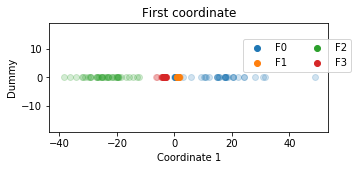

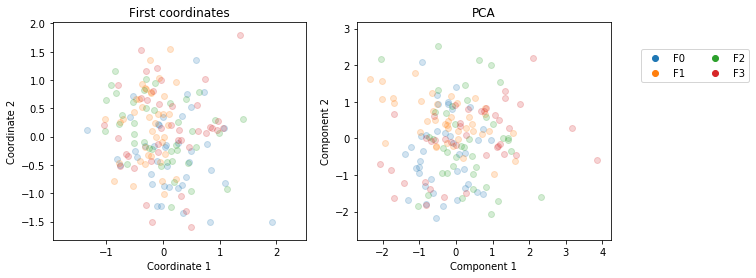

In [9]:
situation_size, message_size, prediction_size, func_size, hidden_size = 10, 1, 10, 4, 64
game = Game(situation_size, message_size, prediction_size, func_size, hidden_size)
print_first = True
for lr in [.01, .001, .0001]:
    playing_game(game, 1000, learning_rate=lr)
    if print_first: 
        print(f"Epoch {game.loss_list[0][0]}:\t{game.loss_list[0][1]:.2e}")
        print_first=False
    print(f"Epoch {game.loss_list[-1][0]}:\t{game.loss_list[-1][1]:.2e}")
plot_messages_information(game, 40)

### Game 1: discussion

The game is easy to play. Discrete signals emerge. There may also be some iconicity left, since the signals seem to spread a bit, possibly in the same way that the actual functions spread information. 

As a baseline, one could test a similar architecture trying to learn the target but without giving the receiver access to the situation, thus showing that the message encodes the function. There isn't much doubt that it would come out as expected, i.e. poorer communication.

# Game 2: 2-dimensional message

We make one change here: the message is of a higher dimension, one that is still too low to encode the target (and where we can still plot things conveniently).

- Messages of dimensionality 2 (i.e. two words, so to speak, even if continuous)
- Targets to be guessed of dimensionality 10
- We fix 4 linear functions, that may apply to derive an information from a situation

Epoch 1:	3.70e-01
Epoch 1000:	3.25e-04
Epoch 2000:	8.85e-06
Epoch 3000:	2.76e-06


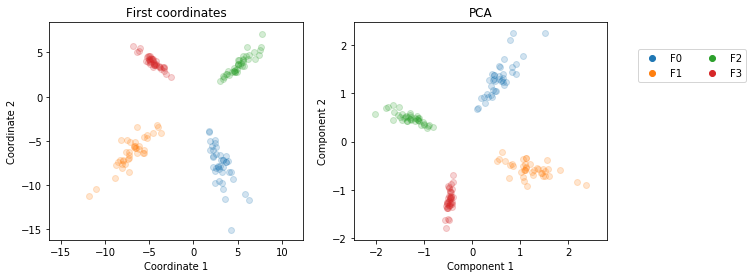

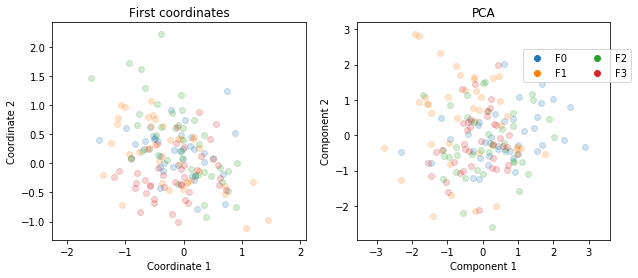

In [17]:
situation_size, message_size, prediction_size, func_size, hidden_size = 10, 2, 10, 4, 64
game = Game(situation_size, message_size, prediction_size, func_size, hidden_size)
print_first = True
for lr in [.01, .001, .0001]:
    playing_game(game, 1000, learning_rate=lr)
    if print_first: 
        print(f"Epoch {game.loss_list[0][0]}:\t{game.loss_list[0][1]:.2e}")
        print_first=False
    print(f"Epoch {game.loss_list[-1][0]}:\t{game.loss_list[-1][1]:.2e}")
plot_messages_information(game, 40)

### Game 2: discussion

The game is, of course, still easy to play, maybe even a bit easier. 

Discrete signals emerge and occupy the 2D space maximally (see the distribution of messages represented in the top row in the graph above). They also spread a bit in a possibly systematic way, in a somewhat centrifugal way.

The intermediate layer thus serves as a language of some sort, and a complex one (for instance, even though it has two parts/dimensions, it is hard to see in what sense this would be a trivially compositional system).

As above, one could evaluate whether this is significantly better than a PCA, say, i.e., to what extent the receiver really uses the signal and the situation to make their guess.

# Game 3: message and information of same dimension

Here we reduce the dimensionality of the situation so that it matches that of the message (2). In principle, there is no need anymore to use the message as a code for the function, nor to use the situation, really: the message could simply be the target.

- Messages of dimensionality 2 
- Information to be guessed of dimensionality 2 - that is, no more than the dimensionality of the messages!
- 4 functions that may apply to derive the information from the situation

Epoch 1:	4.10e-01
Epoch 1000:	1.14e-04
Epoch 2000:	9.88e-06
Epoch 3000:	5.96e-06


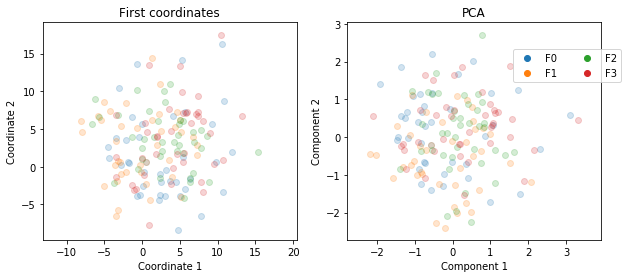

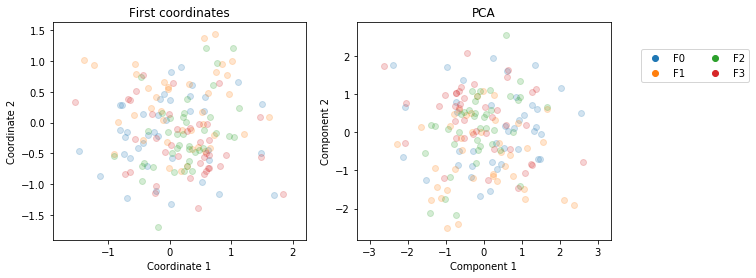

In [11]:
situation_size, message_size, prediction_size, func_size, hidden_size = 10, 2, 2, 4, 64
game = Game(situation_size, message_size, prediction_size, func_size, hidden_size)
print_first = True
for lr in [.01, .001, .0001]:
    playing_game(game, 1000, learning_rate=lr)
    if print_first: 
        print(f"Epoch {game.loss_list[0][0]}:\t{game.loss_list[0][1]:.2e}")
        print_first=False
    print(f"Epoch {game.loss_list[-1][0]}:\t{game.loss_list[-1][1]:.2e}")
plot_messages_information(game, 40)

### Game 3: discussion

We lose the discrete aspect of the messages. The distribution of the messages (top row) actually looks similar to (i.e. as messy as) the distribution of the targets (bottom row). Messages thus now presumably encode the targets directly, which makes sense, since they can. This could be evaluated by showing that the system is no worst if the situation is removed altogether.

Interestingly, this system is not much better than before: the loss follows roughly the same learning path, ending up around $10^{-6}$, even though the target is much less complex too. This suggests that the messages from the previous experiments were quite succesful already at transmitting a code for the functions.

# Game 4: encoding a transformation between functions (compositionality?)

The functions are meant to be the meaning of the messages. Here, we introduce a systematic relation between these functions (meaning), starting to ask whether that transformation itself could be transmitted in the messages. Think about it this way: with a message for $n$ functions $f_0, f_2, ...$ and a message for the transformation, one could create a composite message for twice as many functions (and even more, if the transformation can be applied recursively, and the message as long as one wish).

Specifically, the transformation is a mere multiplication by $\alpha$, such that 
$\forall k: f_{2k+1}=\alpha. f_{2k}$.

Is this transformation ($\alpha$) encoded in the message, e.g., in one of the positions, or in some systematic difference between the message for a function on the left of the equations above and the message for the corresponding function on the right?

We use the following values for the various elements of the game:
- Messages of dimensionality 2 
- Information to be guessed of dimensionality 10
- 4 functions in total: 2 primitive functions, and their 2 transformations

Epoch 1:	4.07e-01
Epoch 1000:	6.19e-03
Epoch 2000:	1.78e-03
Epoch 3000:	2.12e-03


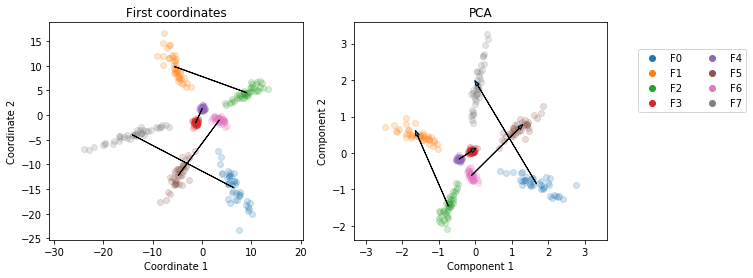

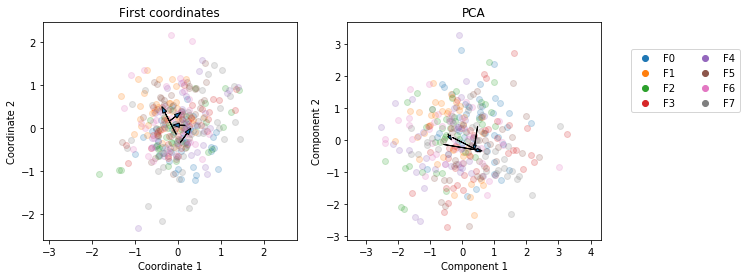

In [15]:
situation_size, message_size, prediction_size, func_size, hidden_size = 10, 2, 10, 4, 64
game = Game(situation_size, message_size, prediction_size, func_size, hidden_size, -1)
print_first = True
for lr in [.01, .001, .0001]:
    playing_game(game, 1000, learning_rate=lr)
    if print_first: 
        print(f"Epoch {game.loss_list[0][0]}:\t{game.loss_list[0][1]:.2e}")
        print_first=False
    print(f"Epoch {game.loss_list[-1][0]}:\t{game.loss_list[-1][1]:.2e}")
plot_messages_information(game, 40)

### Game 4: discussion

In some runs at least, the messages seem to have a much different structure, suggesting that the relations between the functions is picked up on. Putting it boldly, and requiring quite a lot of refinement, it seems that the transformation is encoded as a shift of the message (upward in the simulation above, but note that with negation being an involution, only the orientation should be meaningful, not the direction).

But this requires a lot of caution. First, this did not happen in all runs, I think. Simulations could be particular if the primitive functions themselves are ordered in some way (roughly, here they are on the same side of $0$, therefore moving in the same direction through multiplication by $\alpha$). Hence, the arrows in the graph above about the message may just be reflecting that. Also, different values of $\alpha$ could change this: this could either break the parallelism (because the transformations could be more complex, or their `meaning' could be encoded differently, e.g., by changing the norm of the message, instead of shifting it), or it could help (because more complex relations may become more salient, in the sense that encoding them with one bit in the message could be very efficient).

# Game 5: learning a transformation (from more functions)

How about having more functions (and so more occasions to pick up the transformation)?

We use the following values for the various elements of the game:
- $\alpha=1.2$
- Messages of dimensionality 2 
- Information to be guessed of dimensionality 10
- 40 functions in total: 20 primitive functions, and their 20 transformations

Epoch 1:	4.58e-01
Epoch 1000:	2.27e-01
Epoch 2000:	2.04e-01
Epoch 3000:	1.99e-01


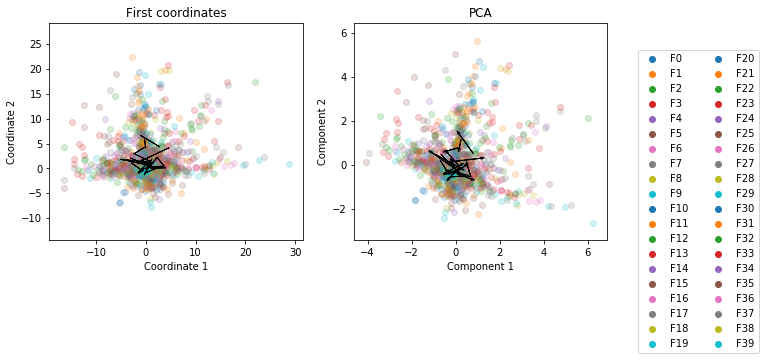

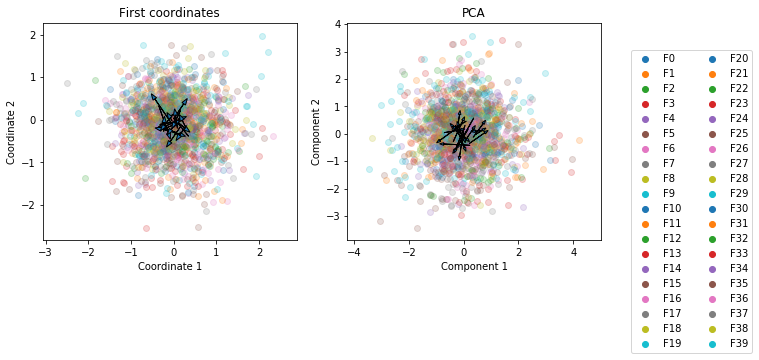

In [16]:
situation_size, message_size, prediction_size, func_size, hidden_size = 10, 2, 10, 20, 64
game = Game(situation_size, message_size, prediction_size, func_size, hidden_size, 1.2)
print_first = True
for lr in [.01, .001, .0001]:
    playing_game(game, 1000, learning_rate=lr)
    if print_first: 
        print(f"Epoch {game.loss_list[0][0]}:\t{game.loss_list[0][1]:.2e}")
        print_first=False
    print(f"Epoch {game.loss_list[-1][0]}:\t{game.loss_list[-1][1]:.2e}")
plot_messages_information(game, 40)

### Game 5: discussion

Now the loss is not great, but there really are much more things to learn. Maybe a change in the training regime could help (as well as dropout, batchnorm, etc.).

It could be that some structure emerges though, whereby the difference vectors follow the $\alpha$ factor. We investigate that in more detail below from a different angle: leaving out some things from training and investigating one-shot learning.

# Game 6: one-shot learning?

The game is the same as above, but we leave out from training:
- two pairs of related functions (0/1 and 2/3), they can serve as baselines for functions not trained on at all.
- two transformed functions, but not the primitive functions they come from (5 and 7 are left out, but 4 and 6 are not).

Do we get better performance on the latter (where transfer could help) than on the former?

Epoch 1:	3.94e-01
Epoch 1000:	2.00e-01
Epoch 2000:	1.78e-01
Epoch 3000:	1.83e-01


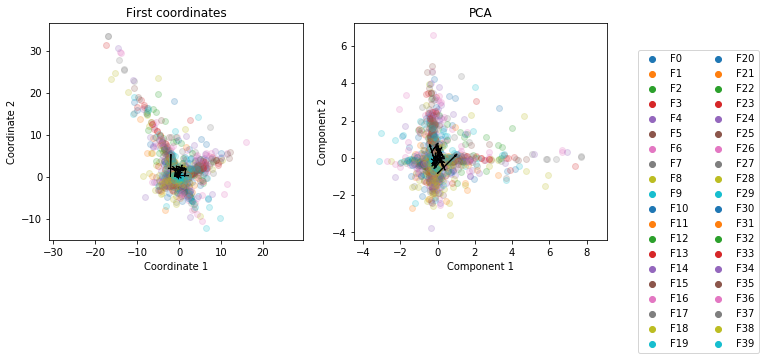

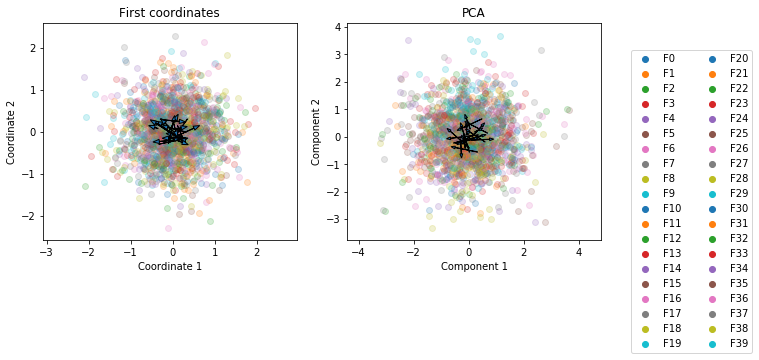

In [19]:
situation_size, message_size, prediction_size, func_size, hidden_size = 10, 2, 10, 20, 64
game = Game(situation_size, message_size, prediction_size, func_size, hidden_size, -1)
print_first = True
for lr in [.01, .001, .0001]:
    playing_game(game, 1000, learning_rate=lr, func_out_training=[0,1,2,3,5,7])
    if print_first: 
        print(f"Epoch {game.loss_list[0][0]}:\t{game.loss_list[0][1]:.2e}")
        print_first=False
    print(f"Epoch {game.loss_list[-1][0]}:\t{game.loss_list[-1][1]:.2e}")
plot_messages_information(game, 40)

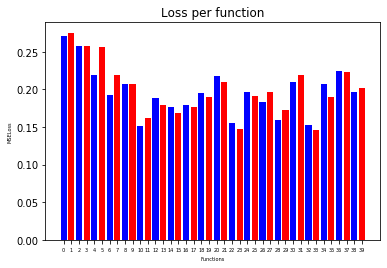

In [20]:
A = plot_losses(game)

### Game 6: discussion

The results are not decisive (i.e. require to be done on a number of replications). Overall, the first 4 (baseline) functions are not learned that bad, and the next two target functions (5 and 7) show up differently from one another (in some runs) and with quite some variability, that falls in between baselines and other cases, making it hard to conclude whether the system did any transfer or not.

Note that there seems to be a good correlation between the loss for a function and its counterpart. This remark could be making a similar point about the encoding of the transformation: once you've learned one, the other comes with the same mistakes. It may however also simply just shows that some functions are easier to learn than others (e.g., because they have a lot of zeroes), and that this learning simplicity is preserved by multiplication by $\alpha$ (which would not be surprising).

# Game 7: training just like game 2, and then testing the effectiveness of discrete (average) messages

This is similar to Game 2, with parameters as below. But now we ask what happens if, once trained, we replaced the messages with average messages. Technically, this is like using discrete messages and use the average messages for the embeddings. (One could thus later continue training on these embeddings, but we'll see how things work without additional training).
- Messages of dimensionality 2 (i.e. two words, so to speak, even if continuous)
- Information to be guessed of dimensionality 10
- We fix 4 linear functions, that may apply to derive an information from a situation

Epoch 1:	3.79e-01
Epoch 1000:	2.18e-04
Epoch 2000:	1.75e-05
Epoch 3000:	3.08e-06


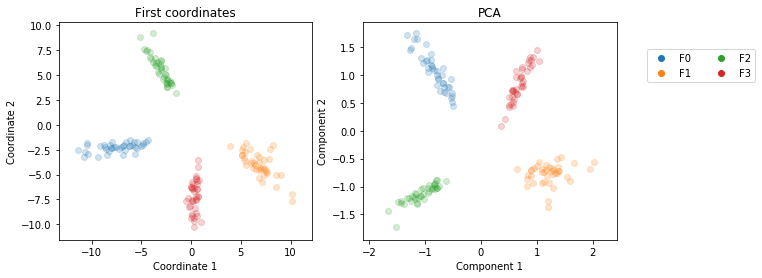

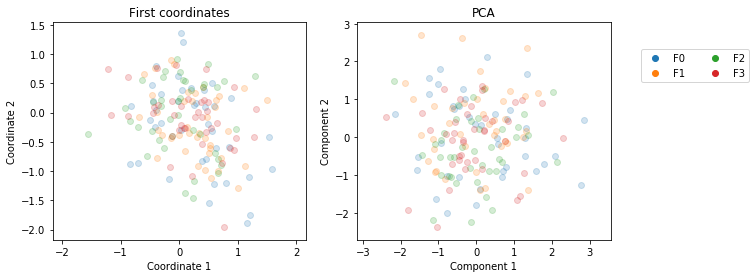

In [53]:
situation_size, message_size, prediction_size, func_size, hidden_size = 10, 2, 10, 4, 64
game = Game(situation_size, message_size, prediction_size, func_size, hidden_size)
print_first = True
for lr in [.01, .001, .0001]:
    playing_game(game, 1000, learning_rate=lr)
    if print_first: 
        print(f"Epoch {game.loss_list[0][0]}:\t{game.loss_list[0][1]:.2e}")
        print_first=False
    print(f"Epoch {game.loss_list[-1][0]}:\t{game.loss_list[-1][1]:.2e}")
plot_messages_information(game, 40)

In [61]:
#Compute the average messages
game.average_messages(100)

replications_per_func = 10
situations = torch.randn(replications_per_func*game.func_size, game.situation_size)
func_switches = torch.cat([torch.arange(game.func_size) for _ in range(replications_per_func)])
targets = game.target(situations, func_switches)

LOSS = game.criterion(game.discrete_forward(situations, func_switches), targets).item()
print(f"Loss: {LOSS:.2e}")

Loss: 2.59e-03


### Game 7: discussion

Before training, loss was around $10^{-1}$, after training it was around $10^{-6}$, now we are around $10^{-3}$. This shows that the average messages carry quite a bit of information. It does not carry all the information either, that is, the original game does take advantage of the additional power available if one uses the actual values, but the discrete version definitely works.

# Todo

It would be useful to think about the expressive power of the architecture more abstractly. Would it make sense to look at other functions (i.e. meanings), maybe functions that a neural network can represent more easily. You may think that linear functions are easy enough, they are easy to learn, but it's not necessarily to learn that they should be applied (for this, we would need the inputs to be the weights). 

Consider two examples: pointwise multiplication or pointwise addition, rather than full linear functions. The message would be able to encode them fully, because they involve a single number. It can also easily implement addition easily if that number is an input, but it's a bit harder for the linear layers to implement multiplication.

One may also ask the question slightly differently: what functions would it be meaningful to investigate in a signaling game (eg, min and max give a lot of what there is in logic).

In choosing functions, we must ask whether:
- messages as we have them can encode the function entirely (that is, give sufficient information to retrieve the function even without a sophisticated code, eg, by sending all the weights transparently)
- a network of this kind can compute such functions
- a network of this kind can re-inject such functions in the network (the distinction between addition and multiplication above)

(NB: Attention may be doing just that for multiplication and other functions, i.e. giving some cells some second-order expressive power, transforming input into parameters of functions, for a range of possible types of functions).